In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,  cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna
from itertools import product
import joblib
import os

c:\Users\APC\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../data/HeartDiseaseTrain-Test.csv")

In [3]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [4]:
duplicated_rows = data[data.duplicated()]
num_duplicates = data.duplicated().sum()
print(f"Số lượng dòng trùng lặp: {num_duplicates}")

data = data[data['vessels_colored_by_flourosopy'] != 'Four']
data = data[data['thalassemia'] != 'No']

data_cleaned = data.drop_duplicates()
print(data_cleaned)

Số lượng dòng trùng lặp: 723
     age     sex   chest_pain_type  resting_blood_pressure  cholestoral  \
0     52    Male    Typical angina                     125          212   
1     53    Male    Typical angina                     140          203   
2     70    Male    Typical angina                     145          174   
3     61    Male    Typical angina                     148          203   
4     62  Female    Typical angina                     138          294   
..   ...     ...               ...                     ...          ...   
723   68  Female  Non-anginal pain                     120          211   
733   44  Female  Non-anginal pain                     108          141   
739   52    Male    Typical angina                     128          255   
843   59    Male      Asymptomatic                     160          273   
878   54    Male    Typical angina                     120          188   

        fasting_blood_sugar               rest_ecg  Max_heart_rate  \


In [5]:
num_new_samples = 1500

bootstrap_samples = data_cleaned.sample(n=num_new_samples, replace=True, random_state=42).reset_index(drop=True)

noise_columns = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
for col in noise_columns:
    noise = np.random.normal(loc=0, scale=data_cleaned[col].std() * 0.05, size=num_new_samples)
    bootstrap_samples[col] += noise
    bootstrap_samples[col] = bootstrap_samples[col].clip(lower=data_cleaned[col].min(), upper=data_cleaned[col].max())

data_augmented = pd.concat([data_cleaned, bootstrap_samples], ignore_index=True)

data_augmented = data_augmented.drop_duplicates()
data_augmented.to_csv("../data/heart_new.csv", index=False)

data = data_augmented

print("Số dòng sau khi tăng cường:", data.shape)

Số dòng sau khi tăng cường: (1796, 14)


In [6]:
data["sex"].replace({"Male" : 1,
                   "Female" : 0}, inplace=True)

data["chest_pain_type"].replace({"Typical angina" : 1,
                                  "Atypical angina" : 2,
                                  "Non-anginal pain" : 3,
                                  "Asymptomatic" : 4}, inplace=True)

data["fasting_blood_sugar"].replace({"Greater than 120 mg/ml" : 1,
                                   "Lower than 120 mg/ml" : 0}, inplace=True)

data["rest_ecg"].replace({"Normal" : 0,
                       "ST-T wave abnormality" : 1,
                       "Left ventricular hypertrophy" : 2}, inplace=True)

data["exercise_induced_angina"].replace({"Yes" : 1,
                                       "No" : 0}, inplace=True)

data["slope"].replace({"Upsloping" : 1,
                     "Flat" : 2,
                     "Downsloping" : 3}, inplace=True)

data["vessels_colored_by_flourosopy"].replace({"Zero" : 0,
                                             "One" : 1,
                                             "Two" : 2,
                                             "Three" : 3}, inplace=True)

data["thalassemia"].replace({"Normal" : 1,
                        "Fixed Defect" : 2,
                        "Reversable Defect" : 3}, inplace=True)
data.head()

C:\Users\APC\AppData\Local\Temp\ipykernel_15932\1858124402.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["sex"].replace({"Male" : 1,
C:\Users\APC\AppData\Local\Temp\ipykernel_15932\1858124402.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["sex"].replace({"Male" : 1,
C:\Users\APC

,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52.0,1,1,125.0,212.0,0,1,168.0,0,1.0,3,2,3,0
1,53.0,1,1,140.0,203.0,1,0,155.0,1,3.1,1,0,3,0
2,70.0,1,1,145.0,174.0,0,1,125.0,1,2.6,1,0,3,0
3,61.0,1,1,148.0,203.0,0,1,161.0,0,0.0,3,1,3,0
4,62.0,0,1,138.0,294.0,1,1,106.0,0,1.9,2,3,2,0


In [ ]:
fig, ax = plt.subplots(figsize=(10.5,6))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", fmt='.2f', annot_kws={"size": 7.5})
plt.title("Correlation Matrix")
plt.show()

In [8]:
selected_features = [
    'age', 'oldpeak', 'Max_heart_rate', 'vessels_colored_by_flourosopy',
    'sex', 'exercise_induced_angina', 'chest_pain_type', 'slope', 'thalassemia', 'target'
]
data = data[selected_features]

C:\Users\APC\AppData\Local\Temp\ipykernel_15932\3366141933.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y=feature, data=data, palette='Set2')


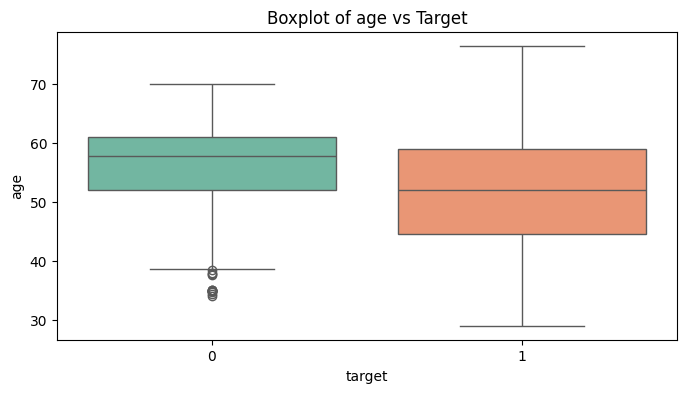

C:\Users\APC\AppData\Local\Temp\ipykernel_15932\3366141933.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y=feature, data=data, palette='Set2')


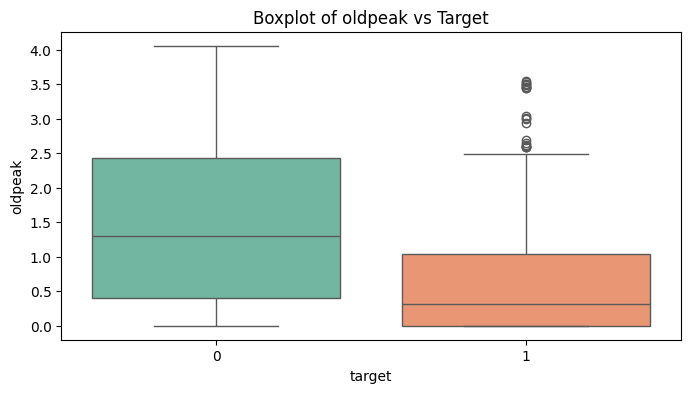

C:\Users\APC\AppData\Local\Temp\ipykernel_15932\3366141933.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y=feature, data=data, palette='Set2')


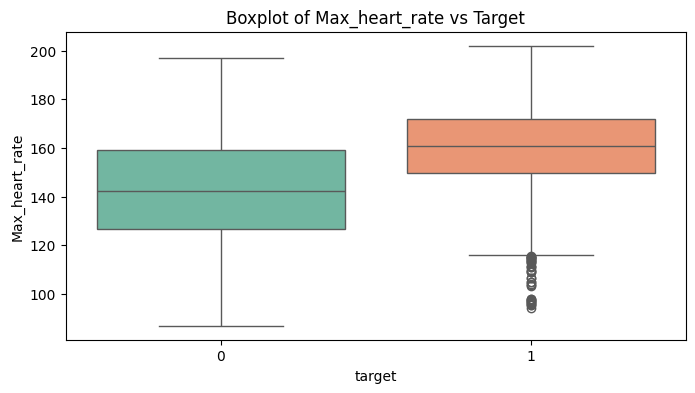

C:\Users\APC\AppData\Local\Temp\ipykernel_15932\3366141933.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y=feature, data=data, palette='Set2')


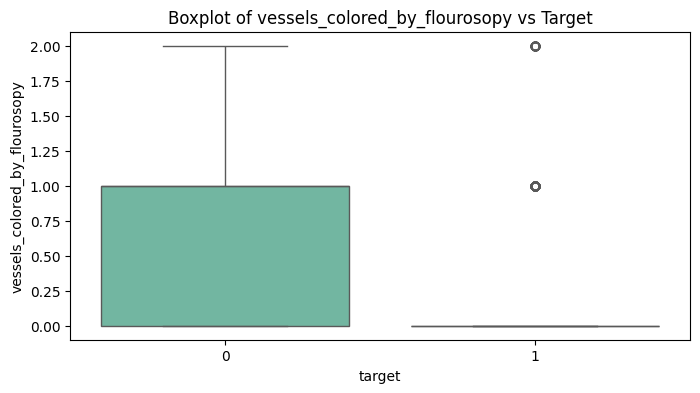

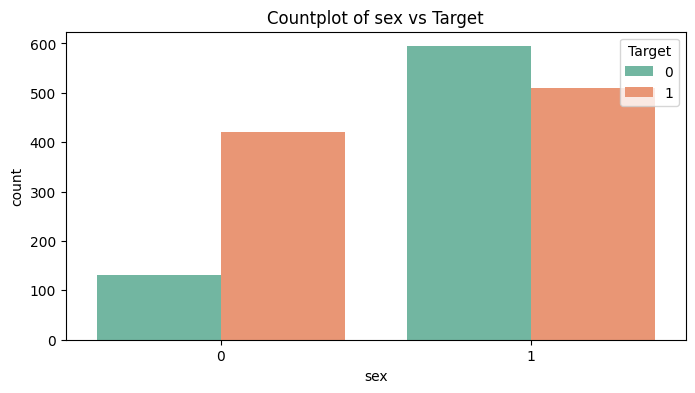

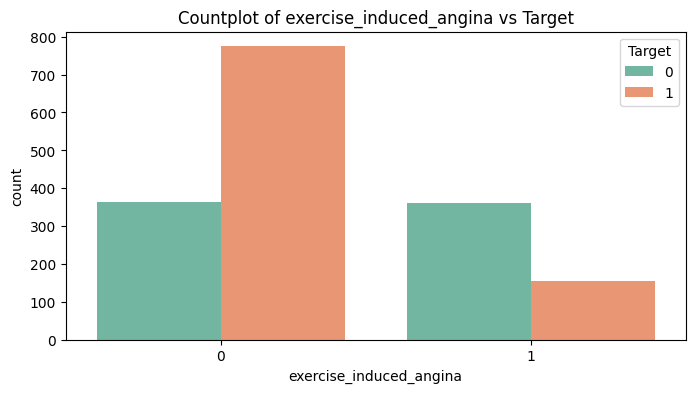

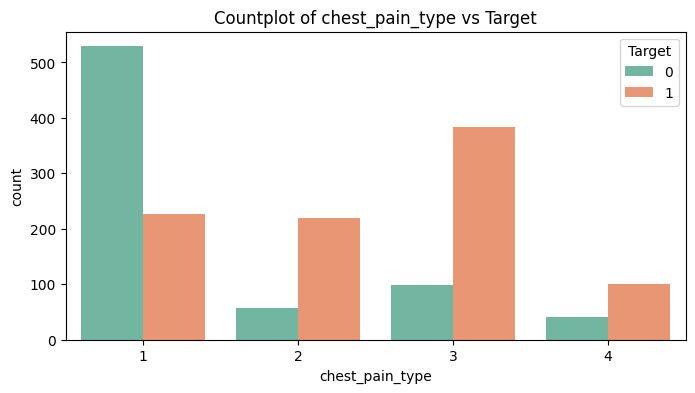

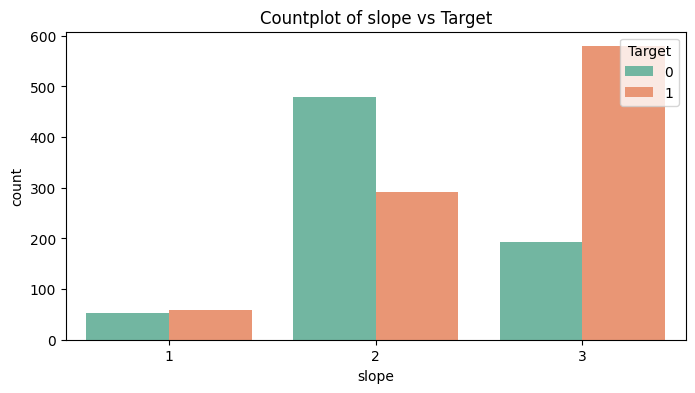

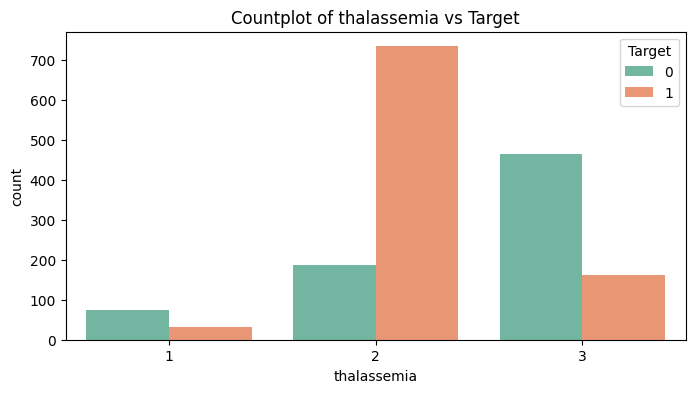

C:\Users\APC\AppData\Local\Temp\ipykernel_15932\3366141933.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=data, palette='coolwarm')


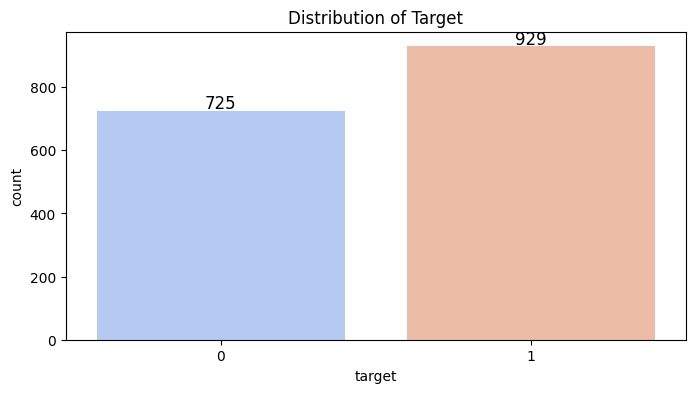

In [21]:
numerical_features = ['age', 'oldpeak', 'Max_heart_rate', 'vessels_colored_by_flourosopy']
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='target', y=feature, data=data, palette='Set2')
    plt.title(f'Boxplot of {feature} vs Target')
    plt.show()

categorical_features = ['sex', 'exercise_induced_angina', 'chest_pain_type', 'slope', 'thalassemia']
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue='target', data=data, palette='Set2')
    plt.title(f'Countplot of {feature} vs Target')
    plt.legend(title='Target', loc='upper right')
    plt.show()

target_counts = data['target'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 4))
ax = sns.countplot(x='target', data=data, palette='coolwarm')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Target')
plt.show()


In [22]:
for col in data.columns[:-1]:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))]

X = data.drop('target', axis=1)
y = data['target']


In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [25]:
models = {
    "Logistic Regression": LogisticRegression,
    "SVM": lambda **kwargs: SVC(probability=True, **kwargs),
    "KNN": KNeighborsClassifier,
    "Decision Tree": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "XGBoost": XGBClassifier
}

In [26]:
def objective_nn(trial):
    units1 = trial.suggest_int("units1", 32, 128)
    units2 = trial.suggest_int("units2", 16, 64)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    model = Sequential([
        Dense(units1, activation="relu", input_dim=X_train.shape[1]),
        Dense(units2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss="binary_crossentropy", metrics=["accuracy"])

    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=0, callbacks=[es])

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    return val_accuracy

In [27]:
train_metrics = {}
val_metrics = {}

for model_name, model_class in models.items():
    model = model_class()
 
    if model_name == "XGBoost":
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss", early_stopping_rounds=10, verbose=False)
    else:
        model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None

    train_metrics[model_name] = {
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred, zero_division=0),
        "Recall": recall_score(y_train, y_train_pred),
        "F1 Score": f1_score(y_train, y_train_pred),
        "ROC AUC": roc_auc_score(y_train, y_train_prob) if y_train_prob is not None else None
    }

    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    val_metrics[model_name] = {
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred, zero_division=0),
        "Recall": recall_score(y_val, y_val_pred),
        "F1 Score": f1_score(y_val, y_val_pred),
        "ROC AUC": roc_auc_score(y_val, y_val_prob) if y_val_prob is not None else None
    }

nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, verbose=0)

train_metrics["Neural Network"] = {
    "Accuracy": history.history['accuracy'][-1],
    "Precision": precision_score(y_train, (nn_model.predict(X_train) > 0.5).astype(int).flatten()),
    "Recall": recall_score(y_train, (nn_model.predict(X_train) > 0.5).astype(int).flatten()),
    "F1 Score": f1_score(y_train, (nn_model.predict(X_train) > 0.5).astype(int).flatten()),
    "ROC AUC": roc_auc_score(y_train, nn_model.predict(X_train).flatten())
}

val_metrics["Neural Network"] = {
    "Accuracy": history.history['val_accuracy'][-1],
    "Precision": precision_score(y_val, (nn_model.predict(X_val) > 0.5).astype(int).flatten()),
    "Recall": recall_score(y_val, (nn_model.predict(X_val) > 0.5).astype(int).flatten()),
    "F1 Score": f1_score(y_val, (nn_model.predict(X_val) > 0.5).astype(int).flatten()),
    "ROC AUC": roc_auc_score(y_val, nn_model.predict(X_val).flatten())
}


train_results = pd.DataFrame(train_metrics).T
val_results = pd.DataFrame(val_metrics).T

print("Training Metrics (before optimization):")
print(train_results)

print("\nValidation Metrics (before optimization):")
print(val_results)

c:\Users\APC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\APC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\APC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Training Metrics (before optimization):
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.839478   0.826994  0.908356  0.865768  0.916572
SVM                  0.950845   0.929114  0.989218  0.958225  0.990309
KNN                  0.994624   0.998643  0.991914  0.995267  0.999723
Decision Tree        1.000000   1.000000  1.000000  1.000000  1.000000
Random Forest        1.000000   1.000000  1.000000  1.000000  1.000000
XGBoost              1.000000   1.000000  1.000000  1.000000  1.000000
Neural Network       0.998464   0.998649  0.995957  0.997301  0.999966

Validation Metrics (before optimization):
                     Accuracy  Precisi

In [28]:
hyperparameters = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    "SVM": {"C": np.logspace(-2, 1, 4), "kernel": ["linear", "rbf"]},
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev'],
    },
    "Decision Tree": {"max_depth": range(1, 5), "min_samples_split": range(2, 5)},
    "XGBoost": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": range(1, 5)},
    "Random Forest": {
        "n_estimators": [10, 50, 100],
        "max_depth": range(3, 10),
        "min_samples_split": range(10, 30),
        "min_samples_leaf": range(5, 20),
        "max_features": ["sqrt", "log2", 0.5, 0.7]
    }
}

tuned_models = {}
tuned_metrics = {}

for model_name, model_class in models.items():
    if model_name != "Neural Network":
        def objective(trial):
            param_grid = hyperparameters.get(model_name, {})
            params = {key: trial.suggest_categorical(key, value) for key, value in param_grid.items()}
            model = model_class(**params)

            if model_name == "XGBoost":
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss", early_stopping_rounds=10, verbose=False)
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

            metrics = {
                "Accuracy": accuracy_score(y_val, y_pred),
                "Precision": precision_score(y_val, y_pred, zero_division=0),
                "Recall": recall_score(y_val, y_pred),
                "F1 Score": f1_score(y_val, y_pred),
                "ROC AUC": roc_auc_score(y_val, y_prob) if y_prob is not None else None
            }
            return metrics["F1 Score"] 

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50) 
        best_params = study.best_params

        best_model = model_class(**best_params)
        if model_name == "XGBoost":
            best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss", early_stopping_rounds=10, verbose=False)
        else:
            best_model.fit(X_train, y_train)

        tuned_models[model_name] = best_model
        y_pred = best_model.predict(X_val)
        y_prob = best_model.predict_proba(X_val)[:, 1] if hasattr(best_model, "predict_proba") else None

        metrics = {
            "Accuracy": accuracy_score(y_val, y_pred),
            "Precision": precision_score(y_val, y_pred, zero_division=0),
            "Recall": recall_score(y_val, y_pred),
            "F1 Score": f1_score(y_val, y_pred),
            "ROC AUC": roc_auc_score(y_val, y_prob) if y_prob is not None else None
        }
        tuned_metrics[model_name] = {
            "Best Params": best_params,
            "Metrics": metrics
        }

study = optuna.create_study(direction="maximize")
def objective_nn(trial):
    units1 = trial.suggest_int("units1", 16, 64)
    units2 = trial.suggest_int("units2", 8, 32)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    model = Sequential([
        Dense(units1, activation="relu", kernel_regularizer=l2(l2_lambda), input_dim=X_train.shape[1]),
        Dropout(dropout_rate),
        Dense(units2, activation="relu", kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=Adam(learning_rate=lr), loss="binary_crossentropy", metrics=["accuracy"])
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
    
    return max(history.history["val_accuracy"])

study.optimize(objective_nn, n_trials=50)
best_nn_params = study.best_params

nn_model = Sequential([
    Dense(best_nn_params["units1"], activation="relu", kernel_regularizer=l2(best_nn_params["l2_lambda"]), input_dim=X_train.shape[1]),
    Dropout(best_nn_params["dropout_rate"]),
    Dense(best_nn_params["units2"], activation="relu", kernel_regularizer=l2(best_nn_params["l2_lambda"])),
    Dropout(best_nn_params["dropout_rate"]),
    Dense(1, activation="sigmoid")
])

nn_model.compile(optimizer=Adam(learning_rate=best_nn_params["lr"]), loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=best_nn_params["batch_size"], verbose=0, callbacks=[early_stopping])

tuned_models["Neural Network"] = nn_model

y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int).flatten()

nn_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_nn),
    "Precision": precision_score(y_test, y_pred_nn, zero_division=0),
    "Recall": recall_score(y_test, y_pred_nn),
    "F1 Score": f1_score(y_test, y_pred_nn),
    "ROC AUC": roc_auc_score(y_test, nn_model.predict(X_test).flatten())
}

tuned_metrics["Neural Network"] = {"Best Params": best_nn_params, "Metrics": nn_metrics}

[I 2025-02-07 14:41:15,440] A new study created in memory with name: no-name-bf5b7cb2-9e07-4ae0-a356-b3a9b3fdb52a
[I 2025-02-07 14:41:15,454] Trial 0 finished with value: 0.8979591836734694 and parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8979591836734694.
[I 2025-02-07 14:41:15,466] Trial 1 finished with value: 0.8717948717948718 and parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8979591836734694.
[I 2025-02-07 14:41:15,476] Trial 2 finished with value: 0.8717948717948718 and parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8979591836734694.
[I 2025-02-07 14:41:15,490] Trial 3 finished with value: 0.8979591836734694 and parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8979591836734694.
[I 2025-02-07 14:41:15,502] Trial 4 finished with value: 0.8979591836734694 and parameters: {'C': 10, 'penalty': 'l2', 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [29]:
tuned_results = pd.DataFrame({
    model_name: {
        "Accuracy": tuned_metrics[model_name]["Metrics"]["Accuracy"],
        "Precision": tuned_metrics[model_name]["Metrics"]["Precision"],
        "Recall": tuned_metrics[model_name]["Metrics"]["Recall"],
        "F1 Score": tuned_metrics[model_name]["Metrics"]["F1 Score"],
        "ROC AUC": tuned_metrics[model_name]["Metrics"].get("ROC AUC")
    } for model_name in tuned_models
}).T

print("Tuned Model Metrics (After Optuna):")
print(tuned_results)

Tuned Model Metrics (After Optuna):
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.877301   0.854369  0.946237  0.897959  0.937942
SVM                  0.975460   1.000000  0.956989  0.978022  0.999386
KNN                  1.000000   1.000000  1.000000  1.000000  1.000000
Decision Tree        0.852761   0.828571  0.935484  0.878788  0.915207
Random Forest        0.963190   0.967742  0.967742  0.967742  0.996774
XGBoost              0.993865   0.989362  1.000000  0.994652  1.000000
Neural Network       0.993865   0.989362  1.000000  0.994652  0.999693


<Figure size 1200x800 with 0 Axes>

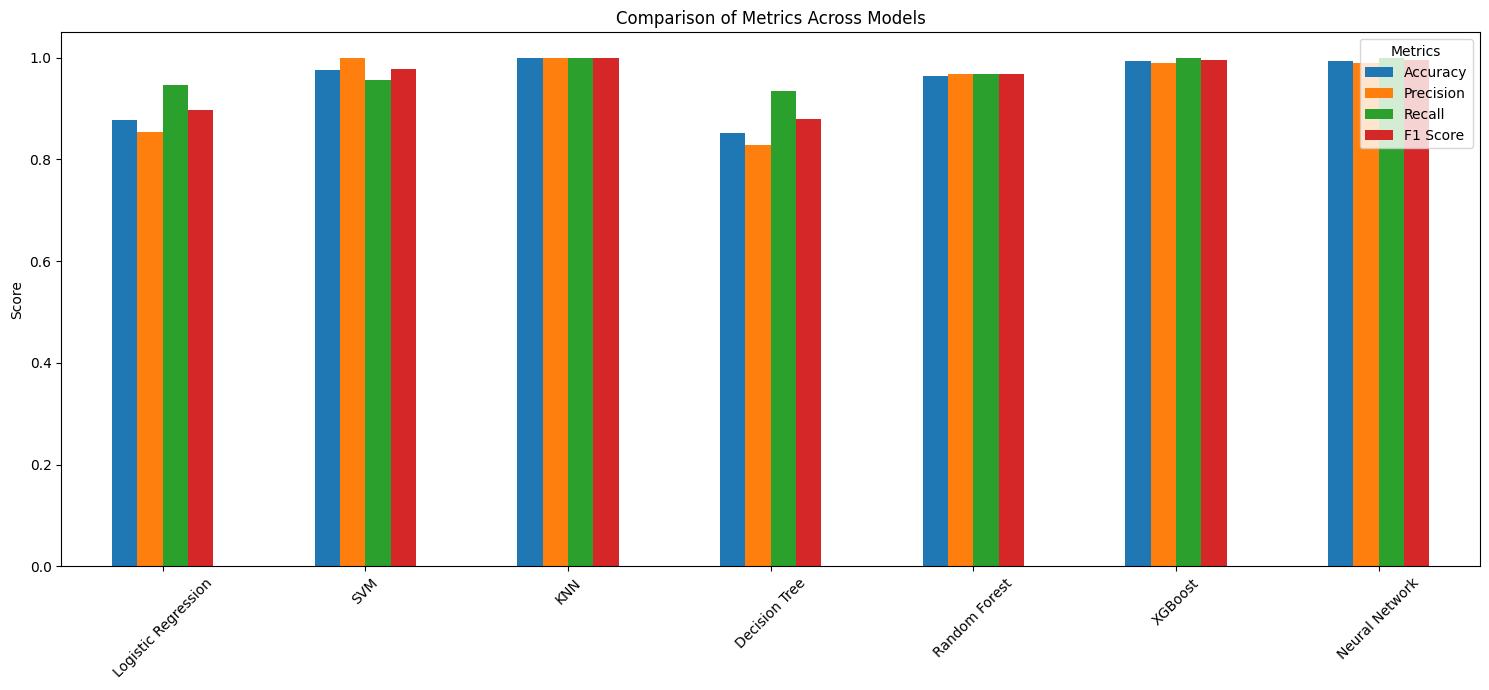

In [30]:
plt.figure(figsize=(12, 8))
tuned_results[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind='bar', figsize=(15, 7))
plt.title("Comparison of Metrics Across Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


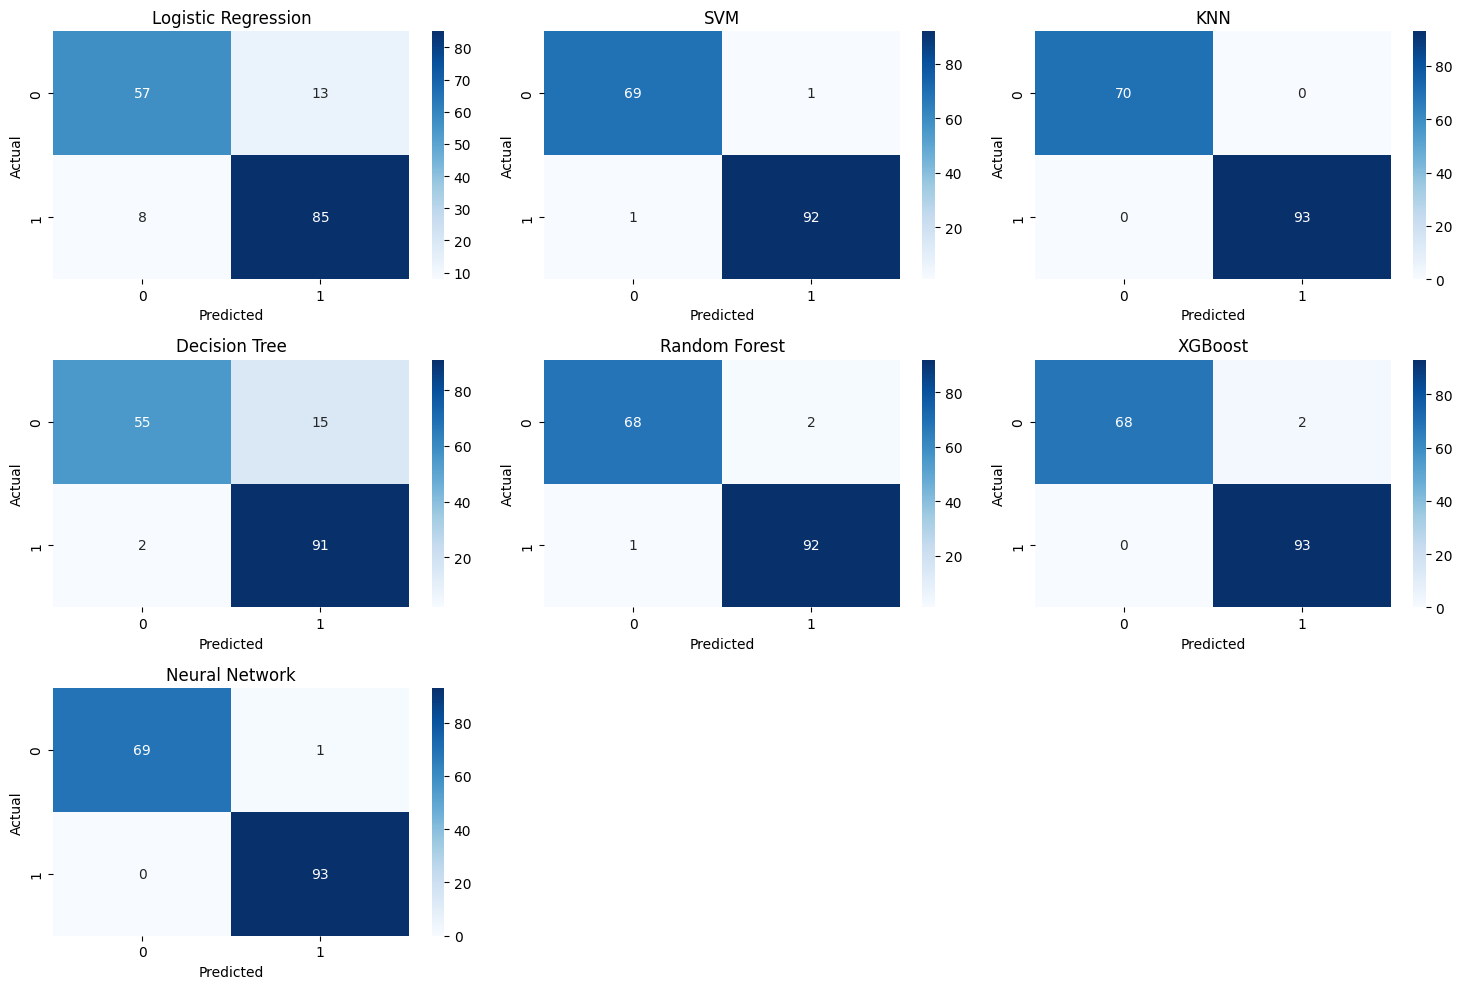

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test Set Metrics (After Optimization):
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.871166   0.867347  0.913978  0.890052  0.915668
SVM                  0.987730   0.989247  0.989247  0.989247  0.999232
KNN                  1.000000   1.000000  1.000000  1.000000  1.000000
Decision Tree        0.895706   0.858491  0.978495  0.914573  0.947158
Random Forest        0.981595   0.978723  0.989247  0.983957  0.998771
XGBoost              0.987730   0.978947  1.000000  0.989362  0.999693
Neural Network       0.993865   0.989362  1.000000  0.994652  0.999693
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


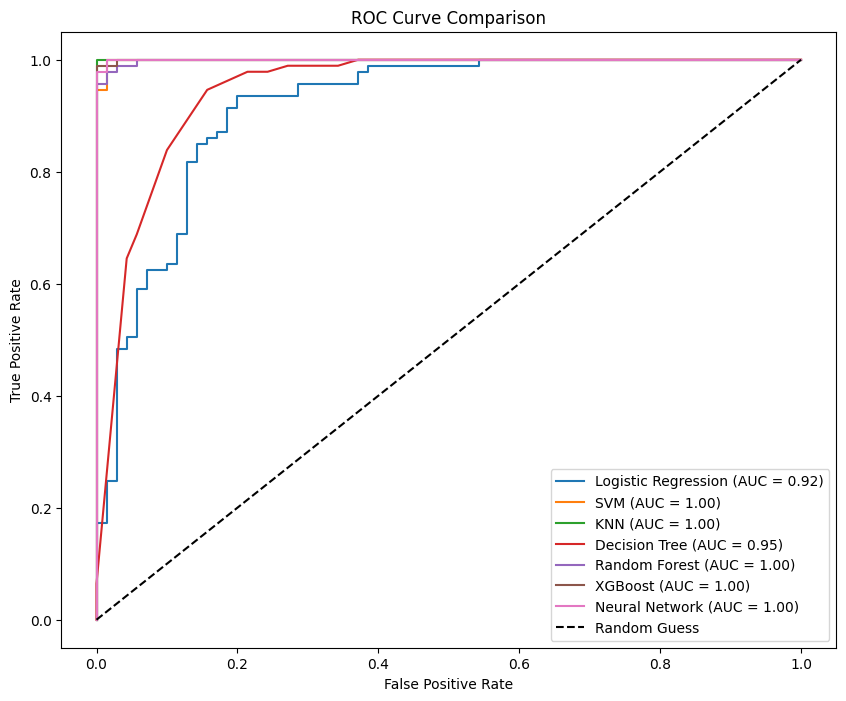

In [36]:
plt.figure(figsize=(15, 10))
for i, (model_name, model) in enumerate(tuned_models.items()):
    if model_name == "Neural Network":
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    else:
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(3, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(model_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

test_metrics = {}

for model_name, model in tuned_models.items():
    if model_name == "Neural Network":
        y_pred_prob = model.predict(X_test).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int) 
    else:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

    test_metrics[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred_prob) 
    }

test_results = pd.DataFrame(test_metrics).T

print("Test Set Metrics (After Optimization):")
print(test_results)

plt.figure(figsize=(10, 8))
for model_name, model in tuned_models.items():
    if model_name == "Neural Network":
        y_pred_prob = model.predict(X_test).flatten()
    elif hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        decision_scores = model.decision_function(X_test)  
        y_pred_prob = 1 / (1 + np.exp(-decision_scores)) 

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [32]:
model_dir = "../model/"
for model_name, model in tuned_models.items():
    if model_name == "Neural Network":
        model.save(os.path.join(model_dir, f"{model_name.replace(' ', '_')}_tuned_model.keras"))
    else:
        joblib.dump(model, os.path.join(model_dir, f"{model_name.replace(' ', '_')}_tuned_model.joblib"))

In [35]:
joblib.dump(scaler, os.path.join(model_dir, "scaler.joblib"))

['../model/scaler.joblib']

In [33]:
for model_name, model in tuned_models.items():
    print(f"Model: {model_name}")
    print(model)

Model: Logistic Regression
LogisticRegression(C=10, solver='liblinear')
Model: SVM
SVC(C=10.0, probability=True)
Model: KNN
KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
Model: Decision Tree
DecisionTreeClassifier(max_depth=4, min_samples_split=4)
Model: Random Forest
RandomForestClassifier(max_depth=8, max_features=0.5, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=50)
Model: XGBoost
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_